In [38]:
pip install pandas matplotlib reverse-geocode

Note: you may need to restart the kernel to use updated packages.


In [20]:
# -----------------------------------------------------------
# NORMALIZE COUNTRY NAMES FROM reverse_geocode
# -----------------------------------------------------------
def normalize_country(name):
    n = name.strip().lower()

    # Democratic Republic of the Congo (Kinshasa)
    if ("democratic" in n and "congo" in n) or ("kinshasa" in n):
        return "DRC"

    # Republic of the Congo (Brazzaville)
    if "republic of the congo" in n or "brazzaville" in n:
        return "Congo"

    # reverse_geocode often returns simply 'Congo'
    if n == "congo":
        return "Congo"

    # Everything else title-case
    return name.title()

In [21]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import calendar
import reverse_geocode
from tqdm import tqdm

# -----------------------------------------------------------
# FOLDER MAPPING 
# -----------------------------------------------------------
FOLDERS = {
    2023: "2023",
    2024: "africa"
}

# -----------------------------------------------------------
# COLUMN CONSTANTS
# -----------------------------------------------------------
LAT_COL = "latitude"
LON_COL = "longitude"
DATE_COL = "acq_date"
FRP_COL = "frp"

# -----------------------------------------------------------
# TARGET COUNTRIES (full names from reverse_geocode)
# -----------------------------------------------------------
TARGET_COUNTRY_NAMES = [
    "Angola", "Madagascar", "Tanzania", "DRC", "Congo",
    "CAR", "South Sudan", "Nigeria", "Guinea", "Ghana",
    "Sierra Leone", "Cameroon", "Gabon", "Zambia", "Zimbabwe",
    "South Africa", "Botswana", "Equatorial Guinea", "Malawi", "Mozambique"
]

# -----------------------------------------------------------
# GEOLOCATION CACHE (to avoid repeated reverse geocode calls)
# -----------------------------------------------------------
_geo_cache = {}

def reverse_geocode_cached(lat, lon):
    key = (round(lat, 3), round(lon, 3))  # rounding helps cache more
    if key not in _geo_cache:
        result = reverse_geocode.search([(lat, lon)])[0]
        _geo_cache[key] = result["country"]
    return _geo_cache[key]


# -----------------------------------------------------------
# PROCESS ONE YEAR OF DATA
# -----------------------------------------------------------
def process_year_stats(folder, year, start_month, end_month, stat_type):
    """Loads CSVs, filters months + countries, computes fire count or mean FRP."""
    
    print(f"\nProcessing {year} ({stat_type})...")

    files = glob.glob(f"{folder}/*.csv")
    if not files:
        print(f"⚠️ No CSV files in folder: {folder}")
        return pd.DataFrame()

    # Load needed columns
    cols = [LAT_COL, LON_COL, DATE_COL]
    if stat_type == "FRP":
        cols.append(FRP_COL)

    df_list = []
    for f in files:
        try:
            df = pd.read_csv(f, usecols=cols)
            df_list.append(df)
        except Exception as e:
            print(f"Failed reading {f}: {e}")

    if not df_list:
        return pd.DataFrame()

    df = pd.concat(df_list, ignore_index=True)

    # Convert and filter by month
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.dropna(subset=[DATE_COL])
    df = df[df[DATE_COL].dt.month.between(start_month, end_month)]

    if df.empty:
        print("No data after month filtering")
        return pd.DataFrame()

    # Reverse geocode
    tqdm.pandas(desc=f"Reverse geocoding {year}")
    df["Country"] = df.progress_apply(
    lambda row: normalize_country(reverse_geocode_cached(row[LAT_COL], row[LON_COL])),
    axis=1
)

    # Filter AFTER normalization
    df = df[df["Country"].isin(TARGET_COUNTRY_NAMES)]

    if df.empty:
        print("⚠️ No matching African target countries")
        return pd.DataFrame()

    # Aggregation
    if stat_type == "COUNT":
        result = df.groupby("Country").size().reset_index(name="Fire_Count")
    else:  # stat_type == "FRP"
        result = df.groupby("Country")[FRP_COL].mean().reset_index(name="Mean_FRP")

    result["Year"] = year
    return result




In [36]:
# -----------------------------------------------------------
# MAIN FUNCTION – COMPARE YEARS
# -----------------------------------------------------------
def compare_fire_stats(start_month, end_month, countries_to_plot, stat_type):
    """
    stat_type = "COUNT" or "FRP"
    Creates a 2023 vs 2024 bar chart + percent-change annotations.
    """

    # Process 2023 + 2024
    df_23 = process_year_stats(FOLDERS[2023], 2023, start_month, end_month, stat_type)
    df_24 = process_year_stats(FOLDERS[2024], 2024, start_month, end_month, stat_type)

    df_all = pd.concat([df_23, df_24], ignore_index=True)

    if df_all.empty:
        print("No data to plot.")
        return

    value_col = "Fire_Count" if stat_type == "COUNT" else "Mean_FRP"

    # Pivot into wide format
    chart = df_all.pivot(index="Country", columns="Year", values=value_col).fillna(0)

    # Restrict to selected countries
    chart = chart.reindex(countries_to_plot)

    # Sort by 2024 values
    if 2024 in chart.columns:
        chart = chart.sort_values(by=2024, ascending=False)

    # ---- Compute percentage change ----
    chart["Pct_Change"] = chart.apply(
        lambda row: ((row[2024] - row[2023]) / row[2023] * 100) if row[2023] > 0 else 0,
        axis=1
    )

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ["#FFA07A", "#FF4500"]  # 2023 = light orange, 2024 = red

    chart[[2023, 2024]].plot(kind="bar", ax=ax, color=colors)

    label = "Fire Count" if stat_type == "COUNT" else "Mean FRP (W)"
    month_str = f"{calendar.month_abbr[start_month]}–{calendar.month_abbr[end_month]}"

    ax.set_title(f"{label} Comparison ({month_str}) — 2023 vs 2024")
    ax.set_ylabel(label)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45, ha="right")

    # ---- Add percent-change annotations above 2024 bars ----
    for i, country in enumerate(chart.index):
        y_2024 = chart.loc[country, 2024]
        pct = chart.loc[country, "Pct_Change"]

        # Format and arrow direction
        arrow = "↑" if pct >= 0 else "↓"
        color = "red" if pct >= 0 else "grey"

        text = f"{arrow} {pct:+.1f}%"

        ax.text(
            i + 0.20,          # position above the 2024 bar (slightly to right)
            y_2024 + (y_2024 * 0.03),  # a bit above the bar
            text,
            ha="center",
            va="bottom",
            fontsize=9,
            color=color,
            fontweight="bold"
        )

    plt.tight_layout()
    plt.show()


In [48]:
df_23 = process_year_stats(FOLDERS[2023], 2023, 1, 12, 'COUNT')
df_24 = process_year_stats(FOLDERS[2024], 2024, 1, 12, 'COUNT')
df_all = pd.concat([df_23, df_24], ignore_index=True)
df_all.to_json("fire_stats.json", orient="records")


Processing 2023 (COUNT)...


Reverse geocoding 2023: 100%|██████████| 4664302/4664302 [00:58<00:00, 79517.13it/s] 



Processing 2024 (COUNT)...


Reverse geocoding 2024: 100%|██████████| 2411961/2411961 [00:18<00:00, 127799.24it/s]



Processing 2023 (COUNT)...


Reverse geocoding 2023: 100%|██████████| 4664302/4664302 [00:30<00:00, 154741.57it/s]



Processing 2024 (COUNT)...


Reverse geocoding 2024: 100%|██████████| 2411961/2411961 [00:14<00:00, 169217.11it/s]


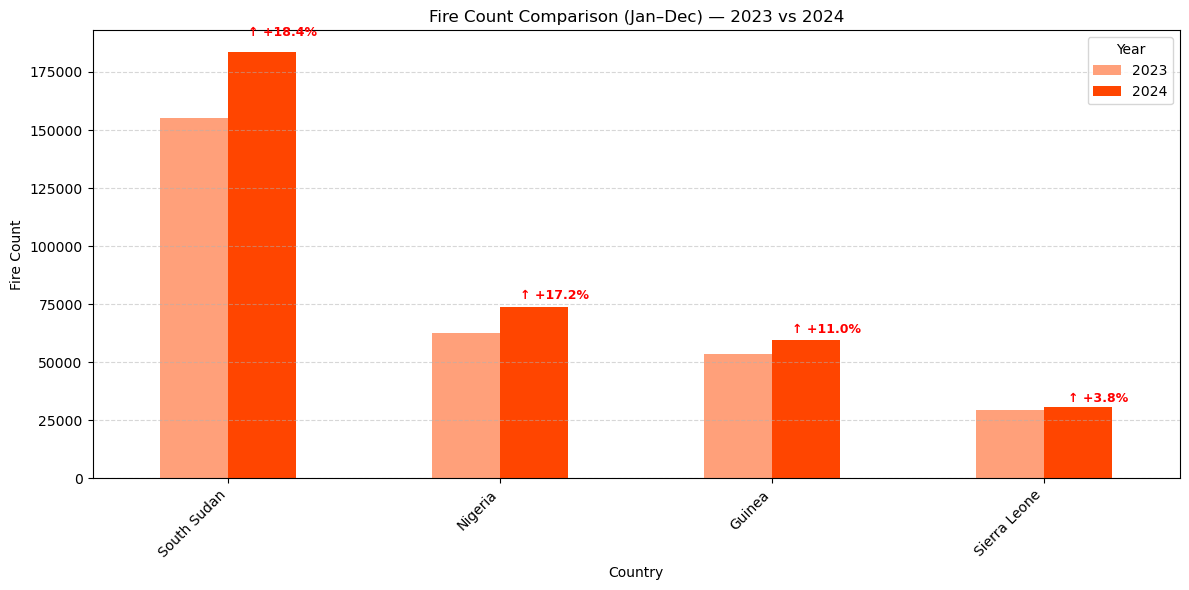

In [37]:
countries = ["Guinea", "Nigeria", "Sierra Leone", "South Sudan"]
compare_fire_stats(1, 12, countries, stat_type="COUNT")



Processing 2023 (COUNT)...


Reverse geocoding 2023: 100%|██████████| 4664302/4664302 [00:27<00:00, 168322.61it/s]



Processing 2024 (COUNT)...


Reverse geocoding 2024: 100%|██████████| 2411961/2411961 [00:15<00:00, 157752.90it/s]


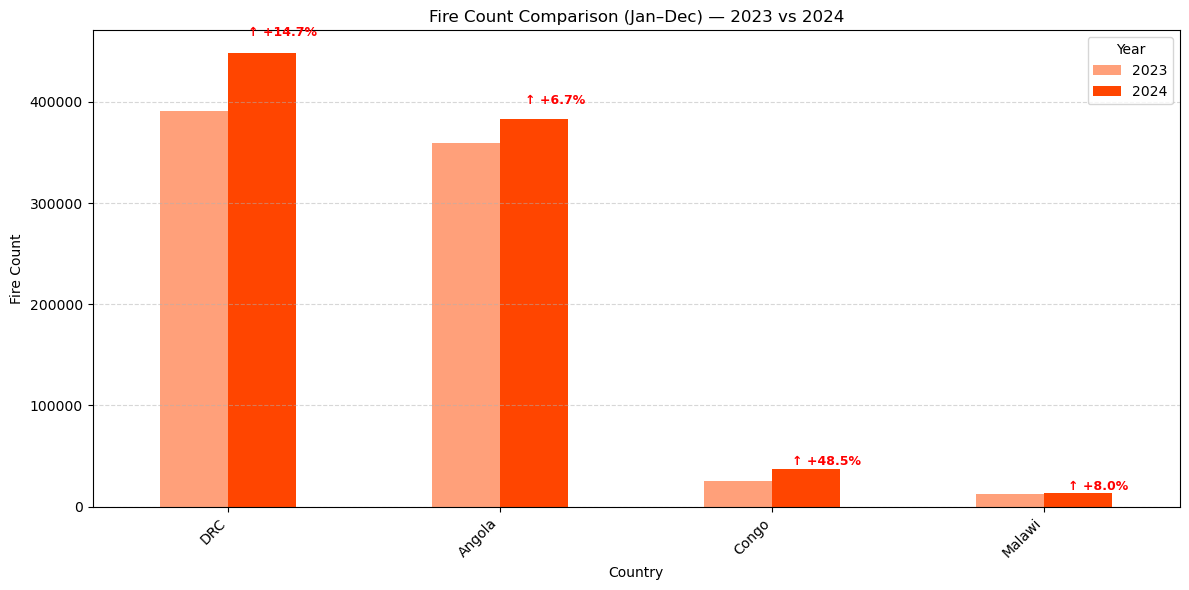

In [38]:
countries = ["Angola", "Malawi", "DRC", "Congo"]
compare_fire_stats(1, 12, countries, stat_type="COUNT")



Processing 2023 (COUNT)...


Reverse geocoding 2023: 100%|██████████| 4664302/4664302 [00:27<00:00, 167538.49it/s]



Processing 2024 (COUNT)...


Reverse geocoding 2024: 100%|██████████| 2411961/2411961 [00:15<00:00, 157424.49it/s]


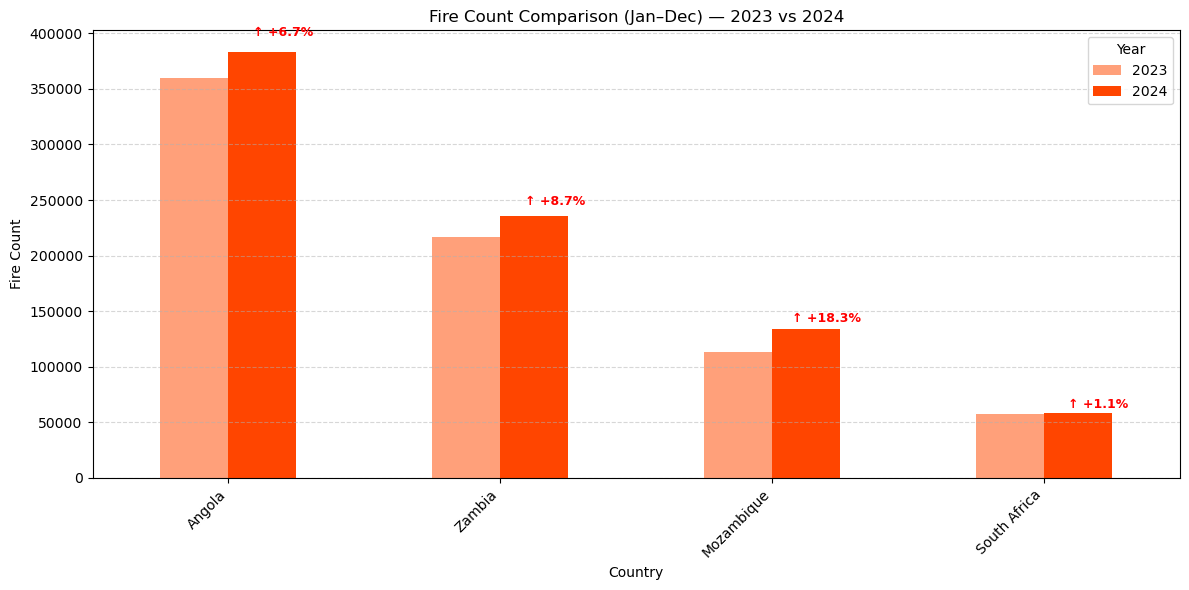

In [39]:
countries = ["Angola", "Zambia", "Mozambique", "South Africa"]
compare_fire_stats(1, 12, countries, stat_type="COUNT")


Processing 2023 (COUNT)...


Reverse geocoding 2023: 100%|██████████| 4664302/4664302 [00:51<00:00, 90301.01it/s] 



Processing 2024 (COUNT)...


Reverse geocoding 2024: 100%|██████████| 2411961/2411961 [00:18<00:00, 129349.56it/s]


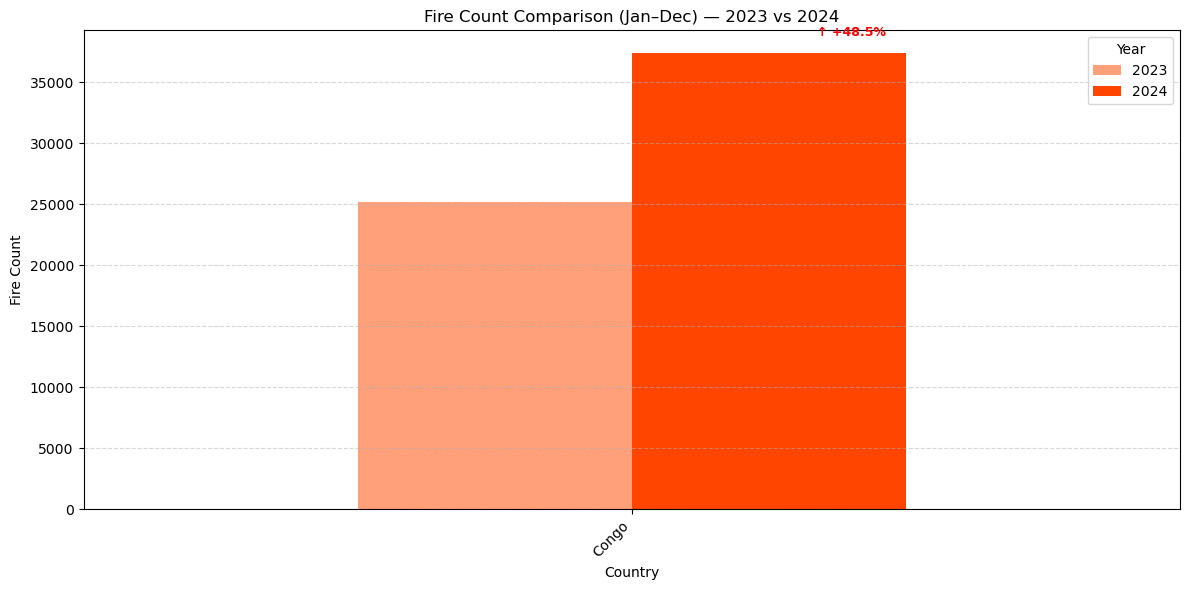

In [47]:
countries = ["Congo"]
compare_fire_stats(1, 12, countries, stat_type="COUNT")